# Missile Guidance with Kalman Filtering
# and Proportional Navigation
### Michael Rose  

The purpose of this notebook is to simulate missile guidance using proportional navigation. This happens in two phases. The position of the plane is measured using a noisy sensor. The Kalman filter then uses the noisy measurements in combination with predictions from a model to make a more accurate guess at the plane's positiion.

Using specs from a MIM-104 Patriot PAC1 and a russian SU-27 at cruise speed at 10,000m  
Missile at origin, plane traveling in y direction offset by x = 10000 m , z = 10000m 

This project aim to combine estimations of a plane's position utilizing Kalman filter with a guidance algorithm called proportional navigation.  

## Proportional Navigation  
Proportional navigation essentially leads a target with constant bearing based on geometry. Rather than constantly orienting the pursuer's velocity vector directly at the target, pro-nav minimizes the flight path by anticipating
where the target will be in the future if a constant bearing is maintained.

### Proportional Navigation Formulas
Below are pro-nav formulas used:  
The required acceleration at each time step is:  
$$\vec{a}= N\vec{V_r} \times \vec{\Omega}$$
Where $\vec{V_r}$ is the target velocity relative to the missile.
$$\vec{V_r} = \vec{V_t} - \vec{V_m} $$
$\vec{\Omega}$ is the rotation vector of the line of sight and can be found with:
$$\vec{\Omega} = \frac{\vec{R} \times \vec{V_r}}    {\vec{R}\cdot \vec{R}} $$
$R$ is the range vector from missile to target:
$$\vec{R} = \vec{R_t}-\vec{R_m} $$

$ N $ is a unitless constant used as a 'gain' to determine how drastic the course correction  
will be at each evolution.


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
import pandas as pd
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
# For offline use
cf.go_offline()
plt.rcParams["figure.figsize"] = (7,7)
np.set_printoptions(precision = 3, suppress = True)

In [299]:
#Define fucntion using pro-nav to update accel of missile
Ngain = 3
def update_accel(target,missile,Ngain):    
    R = (target[0:3,0] - missile[0:3,0]).reshape((3,1))
    Vr = (target[3:,0] - missile[3:,0]).reshape((3,1))
    Omega = np.cross(R,Vr,axis = 0)/(R.T@R)
    a = Ngain*np.cross(Vr,Omega,axis=0)
    return a

In [300]:
pi = np.pi
dt = .1    #10hz

#define params, intial conditions, and uncertainty for plane
#initial uncertainty in pos, same sof
pos_var0 = 500 #m
max_plane_vel = 1553*1609.34/3600     #m/s
plane_vel = 840*1609.34/3600          #m/s

# initial true state of plane
plane_true_state = np.array([[10000, 0, 10000, 0, plane_vel, 0]]).T
a_plane = np.zeros((3,1))

# 99% sure the plane is is within the max speed
# abs(max_speed) is within 3 std 
vel_var0 = (max_plane_vel/3)**2
# 99% sure accel due to windspeed is within 20 m/s^2
accel_var = (20/3)**2   # (m/s^2)^2
#noise in sensor
sensor_var = 25  #m^2

In [301]:
# define params and initial conditions for missile
missile_range = 70000 #m
a_missile = np.zeros((3,1))
missile_range = 70000 #meters
missile_vel = 2.8*343

#States x,y,x, vx, vy, vz
# phi = theta = pi/4 initial angle
missile_state = np.array([[0,0,0,missile_vel*np.sin(pi/4)*np.cos(pi/4),
                     missile_vel*np.sin(pi/4)*np.sin(pi/4),
                     missile_vel*np.cos(pi/4),]]).T

# Kalman Filter
Kalman filters leverage Bayesian statistics in order to take a prior belief (physically predicted positon), and combine that information with a likelihood function (radar measurement) in order to produce a posterior belief (the new estimated position combining both pieces of information.) In this project, those beliefs will be modeled with normal distributions. The filter essentially compares the amount of uncertainty in the physical prediction with the noisy measurement and blends the two while favoring the one with less uncertainty.

I use the convention of Upper Case for Matrices and lower for vectors. 

State evolution prediction:
$$ x_{pred} = Ax_{i-1} + Bu_{i-1} $$
Process Covariance prediction:
$$ P_{pred} = AP_{i-1}A^{T} + Q $$

## Update formulas:
Kalman Gain:
$$ K = P_{pred}H^{T}(HP_{pred}H^{T}+R)^{-1} $$
Residual:
$$ y = z - Hx_{pred} $$
Updating State and Process Covariance:
$$ x_i = x_{pred} + Ky $$
$$ P_i = (I - KH)P_{pred} $$
 

Matrices For Prediction Steps

State Transition Function:
$$
A = \begin{bmatrix} 1 & 0 & 0 & dt & 0 & 0 \\ 0 & 1 & 0 & 0 & dt & 0 \\ 
                    0 & 0 & 1 & 0 & 0 & dt \\ 0 & 0 & 0 & 1 & 0 & 0  \\
                    0 & 0 & 0 & 0 & 1 & 0  \\ 0 & 0 & 0 & 0 & 0 & 1 \end{bmatrix}
$$
State Covariance Matrix  
$$
P = \begin{bmatrix} \sigma_x^2 & 0 & 0 & 0 & 0 & 0 \\ 0 & \sigma_y^2 & 0 & 0 & 0 & 0 \\ 
                    0 & 0 & \sigma_z^2 & 0 & 0 & 0 \\ 0 & 0 & 0 & \sigma_{v_x}^2 & 0 & 0  \\
                    0 & 0 & 0 & 0 & \sigma_{v_y}^2 & 0  \\ 0 & 0 & 0 & 0 & 0 & \sigma_{v_z}^2 \end{bmatrix}
$$
Process Noise  
$$ 
Q = \begin{bmatrix} .25(dt)^4 & 0 & 0 & .5(dt)^3 & 0 & 0 \\ 0 & .25(dt)^4 & 0 & 0 & .5(dt)^3 & 0 \\ 
                    0 & 0 & .25(dt)^4 & 0 & 0 & .5(dt)^3 \\ .5(dt)^3 & 0 & 0 & (dt)^2 & 0 & 0  \\
                    0 & .5(dt)^3 & 0 & 0 & (dt)^2 & 0  \\ 0 & 0 & .5(dt)^3 & 0 & 0 & (dt)^2 \end{bmatrix}
$$ 

Matrices for Update Step  

Sensor Covariance Matrix
$$
R = \begin{bmatrix} \sigma_{sens_x}^2 & 0 & 0 \\ 0 & \sigma_{sens_y}^2 & 0 \\ 0 & 0 & \sigma_{sens_z}^2 \end{bmatrix}
$$

Measurement Function
$$
H = \begin{bmatrix} 1 & 0 & 0 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 & 0 & 0 \\ 
                    0 & 0 & 1 & 0 & 0 & 0 \end{bmatrix}
$$

In [302]:
#setting up matrices for prediction and update steps
pi = np.pi
dt = .1    #10hz
#State Transition Function
A = np.array([[1, 0, 0, dt, 0 ,0],
              [0, 1, 0, 0, dt, 0],
              [0, 0, 1, 0, 0, dt],
              [0, 0, 0, 1, 0 ,0 ], 
              [0, 0, 0, 0, 1 , 0],
              [0, 0, 0, 0, 0,1]])
B = np.array([[.5*dt**2, 0, 0],
              [0, .5*dt**2, 0],
              [0, 0, .5*dt**2],
              [dt, 0, 0], 
              [0, dt, 0],
              [0, 0, dt]])
#State Covariance
#Assuming I have no knowledge of covariance between pos and vel
P = np.array([[pos_var0, 0,0,0,0,0],
              [0, pos_var0,0,0,0,0],
              [0, 0,pos_var0,0,0,0],
              [0, 0,0,vel_var0,0,0],
              [0, 0,0,0,vel_var0,0],
              [0, 0,0,0,0,vel_var0],])

#Process Covariance
#This uses a discrete noise model with constant velocity
Q = np.array([[.25*dt**4, 0, 0, .5*dt**3, 0 ,0],
              [0, .25*dt**4, 0, 0, .5*dt**3, 0],
              [0, 0, .25*dt**4, 0, 0, .5*dt**3],
              [.5*dt**3, 0, 0, dt**2,0 , 0],
              [0, .5*dt**3, 0, 0, dt**2, 0],
              [0, 0, .5*dt**3, 0, 0, dt**2]])*accel_var

#Sensor Noise Covariance
#variance in measured xpos, ypos, zpos
R = np.eye(3)*sensor_var  #wiki says about 25 meters variance?   
# Measurement Function, measurements in meters already
H = np.array([[1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0]])
I = np.eye(6)

In [303]:
# define kalman filter function to be used at each iteration
def kfilter(x, A, Q, P, H, R, I, z):
    # PREDICT STEP
    #predict the state and the process covariance matrix
    
    x_pred = A @ x
    P_pred = A @ P @ A.T + Q
    
    # UPDATE STEP
    #calcultate kalman gain and update the process covariance matrix
    
    S = (H @ P_pred @ H.T) + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    #calculate residual
    y = z - (H @ x_pred)
    # update state using Kalman gain and residual
    x = x_pred + (K @ y)
    #update Process Covar matrix
    P = (I - K @ H) @ P_pred
    return x, P

In [304]:
# define function to update true position of plane and of missile
def update_pos(state,u=np.zeros((3,1)),A=A,B=B):
    state  = A @ state + B @ u
    return state

# simulate measurement by adding noise to true position, leave vel untouched
def measure_pos(plane_true, var): 
    noise = np.append(np.random.randn(3)*var,[0 ,0,0]).reshape(6,1)
    return noise + plane_true

In [305]:
# Take 2 measurements of first 2 evolutions and use these as initial
# state estimates


# records will be kept with observations going down rows, table form
# state will remain col vector
plane_true_record = np.zeros((2,6))
plane_measure_record = np.zeros((2,6))

#record 1st entry
plane_true_record[0,None,:] = plane_true_state.T
plane_measure_record[0,None,:] = measure_pos(plane_true_state, sensor_var).T
#next epoch
plane_true_state = update_pos(plane_true_state,a_plane,A,B)
#record second entries
plane_true_record[1,None,:] = plane_true_state.T
plane_measure_record[1,None,:] = measure_pos(plane_true_state, sensor_var).T

#calculate x0 from latest position measure and vel from latest 2 pos measurement
est_pos = plane_measure_record[1,None,0:3]
est_vel = (plane_measure_record[1,None,0:3]-plane_measure_record[0,None,0:3])/dt
#initial estimate
x0_plane = np.append(est_pos,est_vel).reshape(6,1) #col vector form for Kalman Filter

In [306]:
# Enter kalman filter loop
# true states evolve --> plane measurement taken --> filter gives estimate -->
# --> update planned missile accel --> record values --> repeat
n =180
x = x0_plane
#threshold for kill radius of missile
kill_range = 20 #m
x_states = np.empty((0,6))
Ps       = np.empty((0,6))
zs       = np.empty((0,3))
missile_state_record = missile_state.T #table form 
for i in range(n):
    #evolve true states
    plane_true_state = update_pos(plane_true_state,a_plane,A,B)
    missile_state     = update_pos(missile_state,a_missile,A,B)
    #measure plane
    z = measure_pos(plane_true_state,sensor_var)[0:3]
    #estimate plane pos with kalman
    x, P = kfilter(x, A, Q, P, H, R, I, z)
    
    #update missile accel with new estimated plane pos 
    a_missile = update_accel(x,missile_state,Ngain)
    
    #records for plotting
    x_states = np.vstack((x_states,x.T))
    plane_true_record    =  np.vstack((plane_true_record,plane_true_state.T))
    missile_state_record =  np.vstack((missile_state_record,missile_state.T))
    zs = np.vstack((zs, z.T))
    #only interested in keeping the variances
    Ps = np.vstack((Ps,np.diag(P)))
    dist = np.linalg.norm((missile_state-plane_true_state)[0:3])
    
    if dist <kill_range:
        print("Boom")
        break

Boom


In [307]:
#Align the states in time: 
#plane_true_record 1st two states were for initial estimates, throw 0,1 away
# first missile state at origin enters loops and should start at first evolution, throw 0 away
#plane kalman estimates begin as loop begins, no correction needed

plane_true_record = np.delete(plane_true_record,[0,1],0)
missile_state_record = np.delete(missile_state_record,0,0)

In [326]:
#This will plot the estimates from the filter along with the  95% confidence interval at each point
def plotter(data_x,data_y,var):
    std = np.sqrt(var)
    upper = data_y+3*std
    lower = data_y-3*std
    plt.plot(data_x,data_y, color = "k")
    plt.plot(data_x, upper, linestyle=":", color="b",lw=1)
    plt.plot(data_x, lower, linestyle=":", color="b",lw=1)
    plt.fill_between(data_x, lower, upper, facecolor='blue',
                    alpha=.2)
    plt.legend()

In [309]:
#Consolidate graphing data into 1 dataframe
time = np.arange(len(x_states))*dt

filter_df = pd.DataFrame(x_states[:,:3],columns = ["x",'y','z'])
filter_df['object'] = "plane_filter"
filter_df['time'] = time

plane_true_df = pd.DataFrame(plane_true_record[:,:3],columns = ["x",'y','z'])
plane_true_df['object'] = "plane"
plane_true_df['time'] = time

missile_df = pd.DataFrame(missile_state_record[:,:3],columns = ["x",'y','z'])
missile_df['object'] = "missile"
missile_df['time'] = time

data = pd.concat((filter_df, plane_true_df, missile_df))


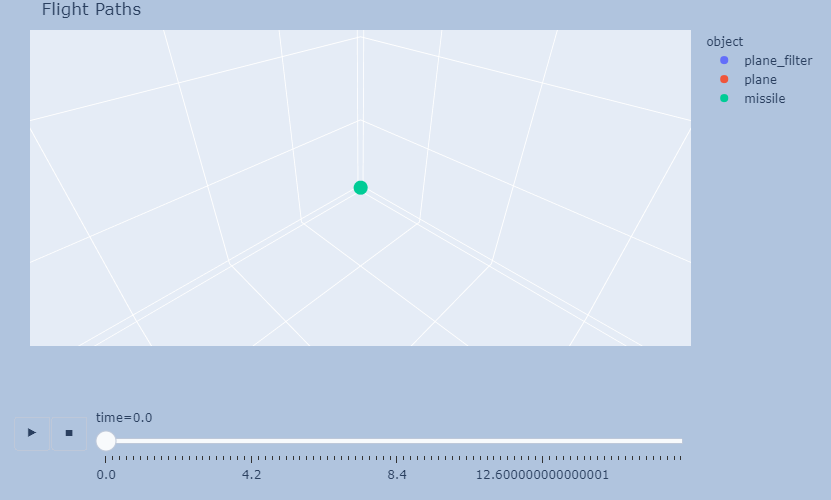

In [310]:
fig = px.scatter_3d(data.iloc[::2,:], x="x", y="y", z="z", color = "object",animation_frame = 'time',
                    range_x=[-100,12000],range_y=[-100,12000],range_z=[-100,12000], 
                    title = "Flight Paths",width = 500, height = 500)
fig.update_layout(
    margin=dict(l=30, r=30, t=30, b=30),
    paper_bgcolor="LightSteelBlue")
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = .5
fig.layout.updatemenus[0].y=0
fig.show()

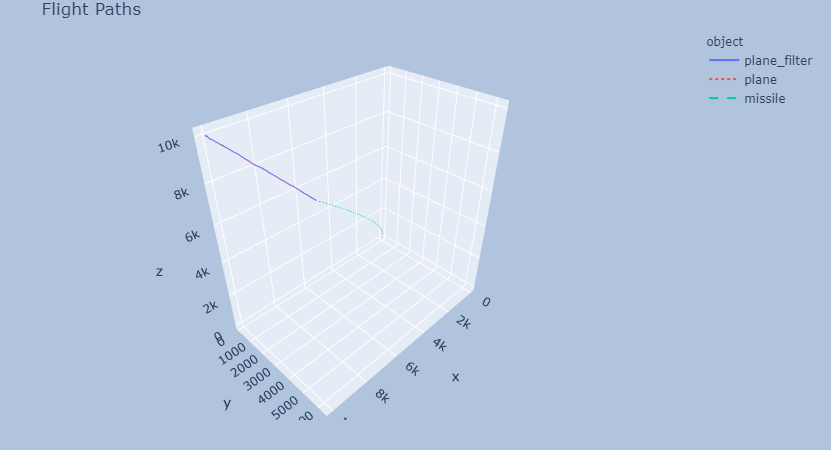

In [311]:
fig = px.line_3d(data, x="x", y="y", z="z", color = "object", line_dash="object", 
                title = "Flight Paths")
fig.update_layout(
    margin=dict(l=30, r=30, t=30, b=30),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

In [322]:
filter_df.head()

,x,y,z,object,time
0,9980.526686,60.765826,10019.114852,plane_filter,0.0
1,10017.729629,94.309651,10012.152522,plane_filter,0.1
2,10012.699317,195.204015,10011.093923,plane_filter,0.2
3,9990.752095,187.631810,10035.760923,plane_filter,0.3
4,9992.250343,263.083715,9993.114089,plane_filter,0.4


No handles with labels found to put in legend.


Text(0, 0.5, 'X position (m)')

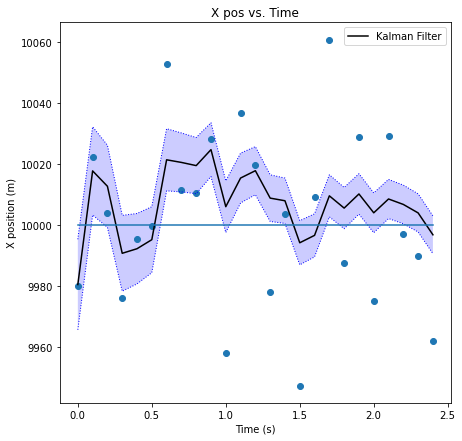

In [338]:
#plt.plot(time,filter_df.iloc[:,0],time,plane_true_df.iloc[:,0],
         #'--',time,zs[:,0],'ko')
fig = plt.figure()
ax = fig.add_subplot(111)
plotter(time[0:25],filter_df.iloc[:25,0],Ps[:25,0])
ax.scatter(time[0:25],zs[:25,0])
ax.plot(time[0:25],plane_true_df.iloc[:25,0])
plt.legend(['Kalman Filter'])
plt.title("X pos vs. Time")
plt.xlabel("Time (s)")
plt.ylabel("X position (m)")

Text(0, 0.5, 'Y position (m)')

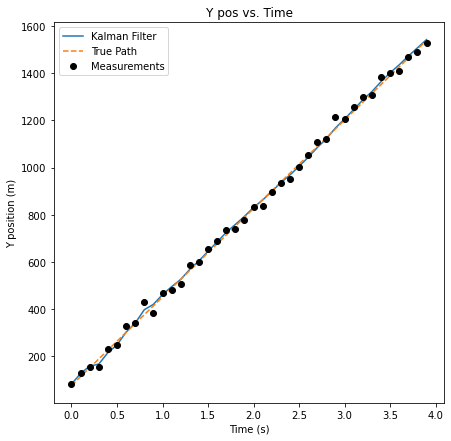

In [216]:
plt.plot(timevec,x_states[:,1],timevec,plane_true_record[2:,1],
         '--',timevec,zs[:,1],'ko')
plt.legend(['Kalman Filter','True Path','Measurements'])
plt.title("Y pos vs. Time")
plt.xlabel("Time (s)")
plt.ylabel("Y position (m)")

Text(0, 0.5, 'Z position (m)')

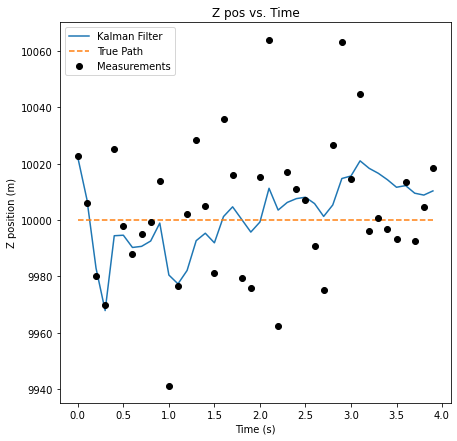

In [218]:
plt.plot(timevec,x_states[:,2],timevec,plane_true_record[2:,2],
         '--',timevec,zs[:,2],'ko')
plt.legend(['Kalman Filter','True Path','Measurements'])
plt.title("Z pos vs. Time")
plt.xlabel("Time (s)")
plt.ylabel("Z position (m)")

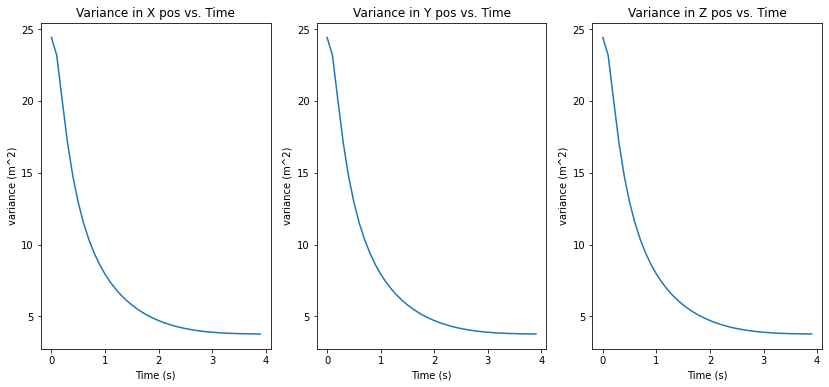

In [219]:
# Process Variances across time
fig = plt.figure(figsize = (14,6))
ax1 = fig.add_subplot(131)
plt.xlabel("Time (s)")
plt.ylabel("variance (m^2)")
plt.title("Variance in X pos vs. Time")
ax1.plot(timevec, Ps[:,0])

ax2 = fig.add_subplot(132)
plt.xlabel("Time (s)")
plt.ylabel("variance (m^2)")
plt.title("Variance in Y pos vs. Time")
ax2.plot(timevec, Ps[:,1])

ax3 = fig.add_subplot(133)
plt.xlabel("Time (s)")
plt.ylabel("variance (m^2)")
plt.title("Variance in Z pos vs. Time")
ax3.plot(timevec, Ps[:,2])


In [273]:
fig.layout.updatemenus[0]

layout.Updatemenu({
    'buttons': [{'args': [None, {'frame': {'duration': 0.5, 'redraw': True},
                          'mode': 'immediate', 'fromcurrent': True, 'transition':
                          {'duration': 500, 'easing': 'linear'}}],
                 'label': '&#9654;',
                 'method': 'animate'},
                {'args': [[None], {'frame': {'duration': 0, 'redraw': True},
                          'mode': 'immediate', 'fromcurrent': True, 'transition':
                          {'duration': 0, 'easing': 'linear'}}],
                 'label': '&#9724;',
                 'method': 'animate'}],
    'direction': 'left',
    'pad': {'r': 10, 't': 70},
    'showactive': False,
    'type': 'buttons',
    'x': 0.1,
    'xanchor': 'right',
    'y': 0.5,
    'yanchor': 'top'
})